# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 1 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V
- Temporal data (Months, Weekdays, Days, Hours)

Model
- See "Architecture"

Result

In [1]:
import os
# Suppress TensorFlow logging (2 = ERROR only, 3 = no logs)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_VMODULE'] = ''

# Suppress XLA/CUDA warnings
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

# Then import tensorflow
import tensorflow as tf
# file locations
# for libs.plotting
import sys
sys.path.append("/workspace/notebooks")  # Changed from /workspace

# for the model checkpoint callback (if enabled)
model_checkpoint_file = '/workspace/notebooks/experiment_output/basic_experiments/model.keras'  # Updated path

# where the training data is stored
data_path = "/workspace/notebooks/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters (these remain the same)
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box (these remain the same)
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape (these remain the same)
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32
FORCE_CPU = False  # Keep this False to use your RTX 5080!

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

2025-07-23 05:24:55.055723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 05:24:55.064981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 05:24:55.067929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


In [2]:
import os

# Check current directory
print("Current directory:", os.getcwd())

# Check if the data path exists
print("\nData path exists:", os.path.exists(data_path))

# List files in the data directory
if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"\nFiles in {data_path}:")
    for f in files[:10]:  # Show first 10 files
        print(f"  - {f}")
else:
    # Try to find where the data actually is
    print("\nSearching for data files...")
    for root, dirs, files in os.walk("/tf/notebooks"):
        if "AirNow_PM25_X_train.npy" in files:
            print(f"Found data at: {root}")
            break

Current directory: /workspace/notebooks/pwwb-experiments/tensorflow/temporal_encoding_model_archive

Data path exists: True

Files in /workspace/notebooks/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/:
  - Y_train.npy
  - Y_test.npy:Zone.Identifier
  - Y_valid.npy
  - Y_train.npy:Zone.Identifier
  - METAR_Wind_V_X_valid.npy
  - AirNow_PM25_X_valid.npy
  - METAR_Wind_U_X_test.npy
  - METAR_Wind_V_X_train.npy:Zone.Identifier
  - METAR_Wind_V_X_test.npy
  - AirNow_PM25_X_test.npy


In [3]:
import tensorflow as tf

# Force TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Force GPU to be used
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print(f"Forcing GPU: {gpus[0]}")
    
    # Optional: Set memory growth to avoid OOM errors
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU found!")
    
# Verify GPU is being used
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.test.is_gpu_available())

Forcing GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


I0000 00:00:1753248296.507251    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248296.536744    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248296.536776    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248296.544081    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248296.544121    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# Data Ingestion and Preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [5]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [6]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [7]:
X_train_2 = np.load(f"{data_path}Temporal_Encoding_X_train.npy")
X_test_2 = np.load(f"{data_path}Temporal_Encoding_X_test.npy")
X_valid_2 = np.load(f"{data_path}Temporal_Encoding_X_valid.npy")

# Add Cyclical Hour Encoding

## Problem with Linear Hour Encoding (or One-Hot Encoding)

Traditional encoding methods create artificial discontinuities:

### One-Hot Encoding Issue:
```
11 PM (hour 23): [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
Midnight (hr 0): [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
```
- These vectors are maximally different (no overlap)
- But 11 PM and midnight are only 1 hour apart!

### Linear Encoding Issue:
- Hour 23 (11 PM) = 23
- Hour 0 (12 AM) = 0
- Distance = 23 (maximum possible)
- But temporally, they are adjacent

## Solution: Cyclical Encoding

Transform hours into sine and cosine components that wrap around a circle:
- `hour_sin = sin(2π * hour / 24)`
- `hour_cos = cos(2π * hour / 24)`

This ensures:
- 11 PM (hour 23) and 12 AM (hour 0) are close in the feature space
- Smooth transitions between all adjacent hours
- No artificial "jump" at midnight
- Better captures the cyclical nature of daily patterns

## Why This Matters for Air Quality

PM2.5 concentrations often follow daily cycles:
- Rush hour peaks
- Overnight minimums
- Temperature-driven patterns

The model needs to understand that 11 PM patterns naturally flow into 12 AM patterns, which cyclical encoding provides.


In [8]:
import numpy as np
import pandas as pd

print("Original temporal encoding shape:", X_train_2.shape)

# Generate timestamps for the entire dataset
timestamps = pd.date_range(start=START_DATE, end=END_DATE, freq='H')

# Calculate where each dataset starts
n_train = len(X_train_2)
n_valid = len(X_valid_2)
n_test = len(X_test_2)

def add_cyclical_hour_encoding(X_temporal, start_idx, timestamps, frames_per_sample=5):
    n_samples = X_temporal.shape[0]
    n_features = X_temporal.shape[2]
    
    X_temporal_new = np.zeros((n_samples, frames_per_sample, n_features + 2))
    
    # Copy existing features
    X_temporal_new[:, :, :n_features] = X_temporal
    
    for i in range(n_samples):
        hours = timestamps[start_idx + i : start_idx + i + frames_per_sample].hour
        X_temporal_new[i, :, n_features] = np.sin(2 * np.pi * hours / 24)      # hour_sin
        X_temporal_new[i, :, n_features + 1] = np.cos(2 * np.pi * hours / 24)  # hour_cos
    
    return X_temporal_new

X_train_2 = add_cyclical_hour_encoding(X_train_2, 0, timestamps, frames_per_sample)
X_valid_2 = add_cyclical_hour_encoding(X_valid_2, n_train, timestamps, frames_per_sample)
X_test_2 = add_cyclical_hour_encoding(X_test_2, n_train + n_valid, timestamps, frames_per_sample)

print("New temporal encoding shapes (with cyclical hours):")
print(f"X_train_2: {X_train_2.shape}")
print(f"X_valid_2: {X_valid_2.shape}")
print(f"X_test_2: {X_test_2.shape}")

Original temporal encoding shape: (12274, 5, 74)


/tmp/ipykernel_4772/752108482.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=START_DATE, end=END_DATE, freq='H')


New temporal encoding shapes (with cyclical hours):
X_train_2: (12274, 5, 76)
X_valid_2: (2630, 5, 76)
X_test_2: (2631, 5, 76)


In [9]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = ['Long Beach Signal Hill']

Y_train = Y_train[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_test = Y_test[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_valid = Y_valid[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()

# Model Definition

## Architecture

In [10]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 1, 1)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 1, 1)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 1, 1)

Input shape:   (5, 40, 40, 3)
Output shape:  (1, 1)

Temporal data input
X_train shape: (12274, 5, 76)
X_test shape:  (2631, 5, 76)
X_valid shape: (2630, 5, 76)
Input shape:   (5, 76)



In [11]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

I0000 00:00:1753248299.798433    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248299.798494    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248299.798505    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248299.798660    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753248299.798686    4772 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
'+ptx85' i

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │      9,780 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 76)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 380)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8380)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      8,381 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,452 (310.36 KB)

 Trainable params: 79,452 (310.36 KB)

 Non-trainable params: 0 (0.00 B)

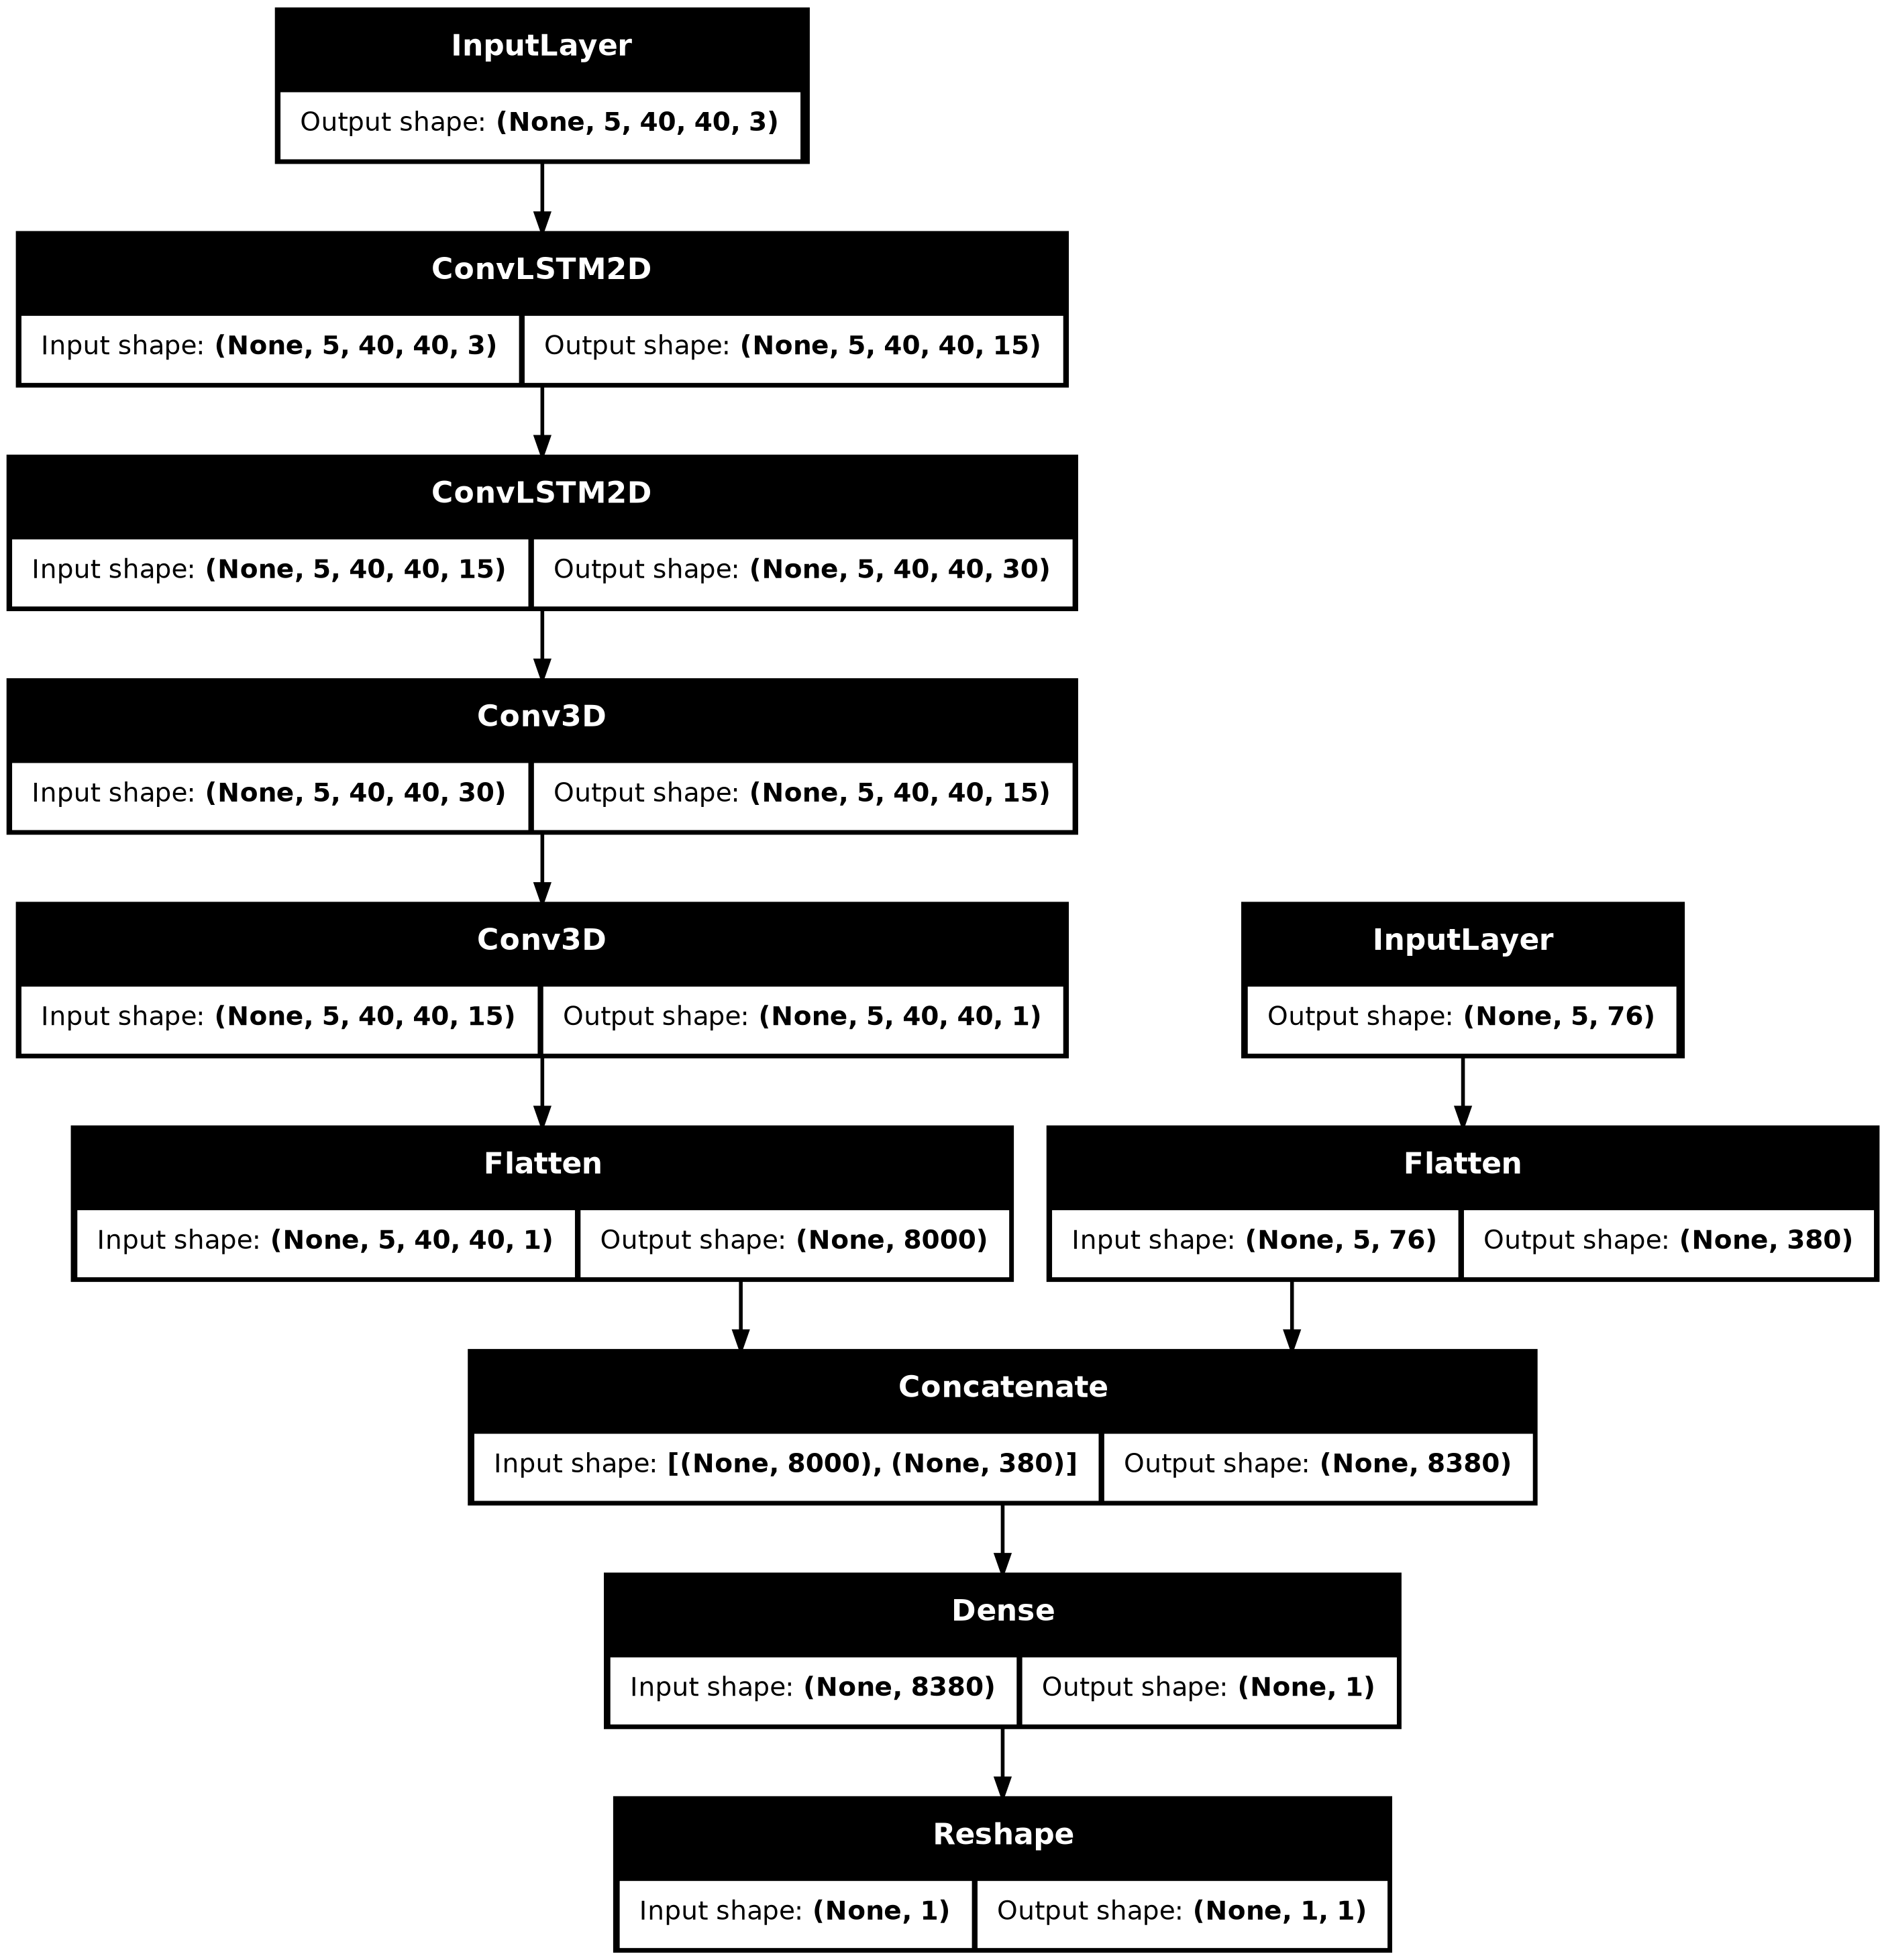

In [12]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [13]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    early_stopping_callback,
    model_checkpoint_callback,
    lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [14]:
# Create the context manager class (put this earlier in your notebook)
import sys
import os

class SuppressStderr:
    def __enter__(self):
        self._original_stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stderr.close()
        sys.stderr = self._original_stderr

# Then wrap your training
with SuppressStderr():
    history = model.fit(
        x=[X_train, X_train_2],
        y=Y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=([X_valid, X_valid_2], Y_valid),
        callbacks=callbacks
    )

Epoch 1/100


I0000 00:00:1753248304.516923    4930 service.cc:146] XLA service 0x35662f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753248304.516961    4930 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


 10/384 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 10.3855 

I0000 00:00:1753248306.415791    4930 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.7062 

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.6967

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 6.6920 - val_loss: 3.7902 - learning_rate: 1.0000e-04
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 3.4322 - val_loss: 3.1024 - learning_rate: 1.0000e-04
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 3.0950 - val_loss: 2.8261 - learning_rate: 1.0000e-04
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 2.8571 - val_loss: 2.9286 - learning_rate: 1.0000e-04
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.7595 - val_loss: 2.7461 - learning_rate: 1.0000e-04
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.6334 - val_loss: 3.0303 - learning_rate: 1.0000e-04
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 2.5916 - val_loss: 2.8002 - learning_rate: 1.0000e-04
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.4974 - val_loss: 2.7431 - learning_rate: 1.0000e-04
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.3859 - val_loss: 2.

# Model Evaluation


Evaluating model


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


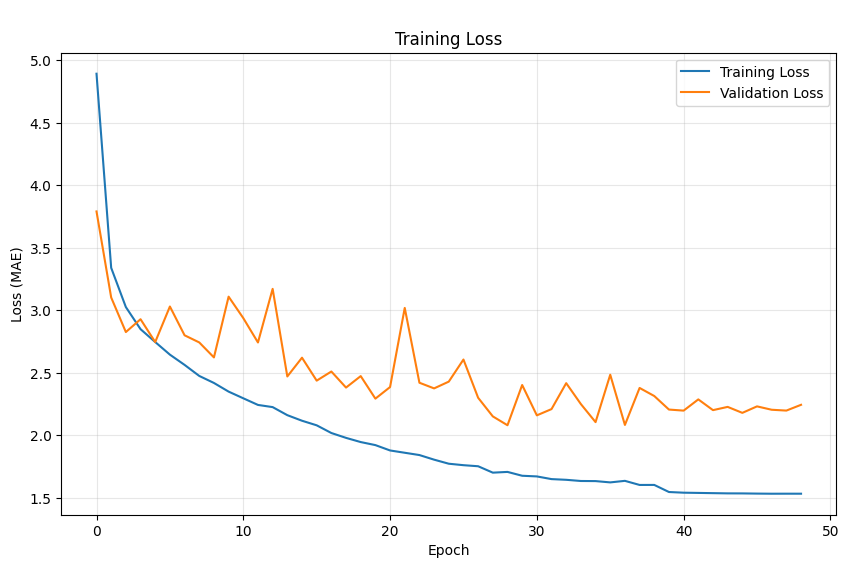

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.407245,1.894649
NRMSE,16.802139,17.299530,13.612247
MAE,1.462357,1.530253,1.148169
R2,0.867632,0.859815,0.913121


In [17]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.407245,1.894649
NRMSE,16.802139,17.299530,13.612247
MAE,1.462357,1.530253,1.148169
R2,0.867632,0.859815,0.913121


In [18]:
# clean up dead sensors; more accurate, also allows us to use mape
from sklearn.metrics import mean_absolute_percentage_error as mape
#mape_err = mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))

dead_sens = np.where(Y_test == 0)
print(f"{len(dead_sens[0])} samples containing dead sensors removed")

cleaned_test = np.delete(Y_test, dead_sens, 0)
cleaned_pred = np.delete(y_pred, dead_sens, 0)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_test[1:]))*100,
        mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))*100,
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_pred[1:]))*100,
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

15 samples containing dead sensors removed


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.119921,1.648717
NRMSE,14.283395,15.145768,11.776163
MAE,1.414116,1.466043,1.099487
MAPE,10.834828,11.061281,8.420780
R2,0.901122,0.888935,0.932789


In [19]:
# first frame results
results = [
    [
        rmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]), 
        rmse(cleaned_pred[:, 0], cleaned_test[:, 0]),
        rmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        nrmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        nrmse(cleaned_pred[:, 0], cleaned_test[:, 0]),        
        nrmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),

    ],
    [        
        mae(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        mae(cleaned_pred[:, 0], cleaned_test[:, 0]),
        mae(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_test[1:, 0]))*100,
        mape(np.squeeze(cleaned_test[:, 0]), np.squeeze(cleaned_pred[:, 0]))*100,
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_pred[1:, 0]))*100,
    ],
    [
        r2_score(cleaned_test[:-1, 0], cleaned_test[1:, 0]),
        r2_score(cleaned_test[:, 0], cleaned_pred[:, 0]),
        r2_score(cleaned_test[:-1, 0], cleaned_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.119921,1.648717
NRMSE,14.283395,15.145768,11.776163
MAE,1.414116,1.466043,1.099487
MAPE,10.834828,11.061281,8.420780
R2,0.901122,0.888935,0.932789


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



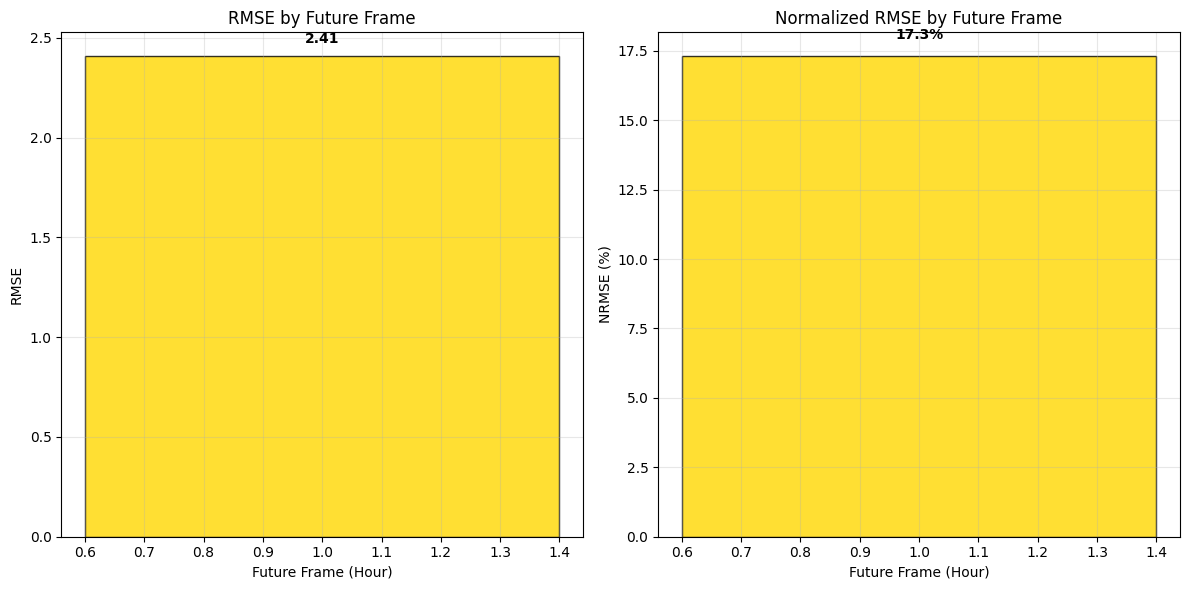


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.407 (17.3%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.407 (17.3%)   │   MAE:  1.530   │   R²:  0.860              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.41   │17.3  %│1.53   │0.860  │

In [20]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



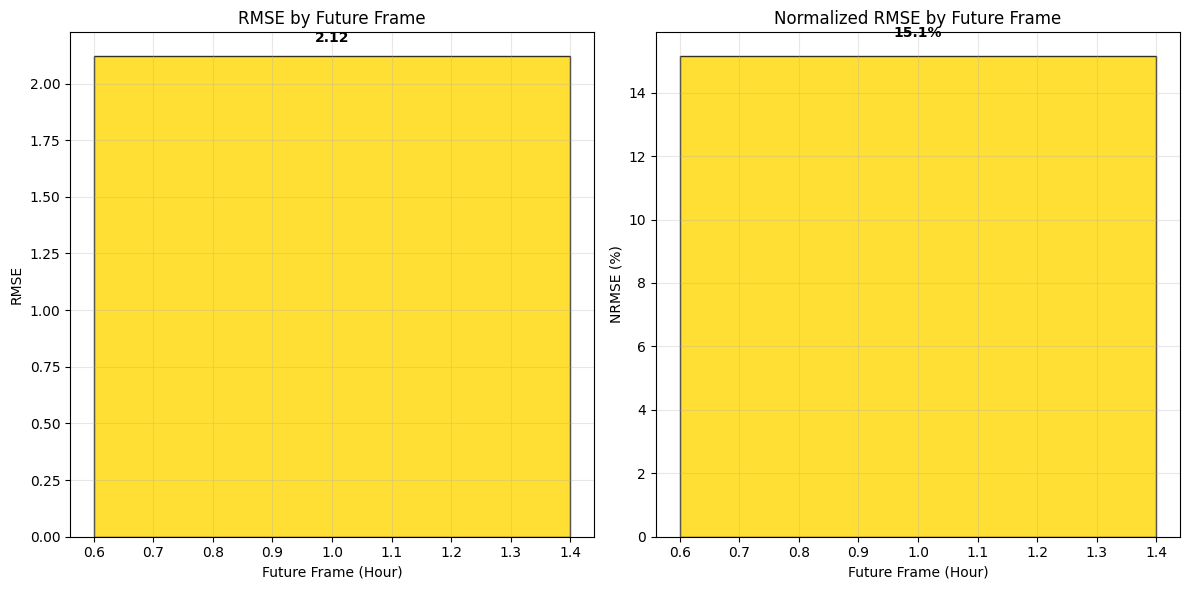


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.120 (15.1%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.120 (15.1%)   │   MAE:  1.466   │   R²:  0.889              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.12   │15.1  %│1.47   │0.889  │

In [21]:
plot_frame_by_frame_rmse(cleaned_pred, cleaned_test)
print_detailed_frame_stats(cleaned_pred, cleaned_test, sensor_names)

# Plots

## Snapshot plots - first frame

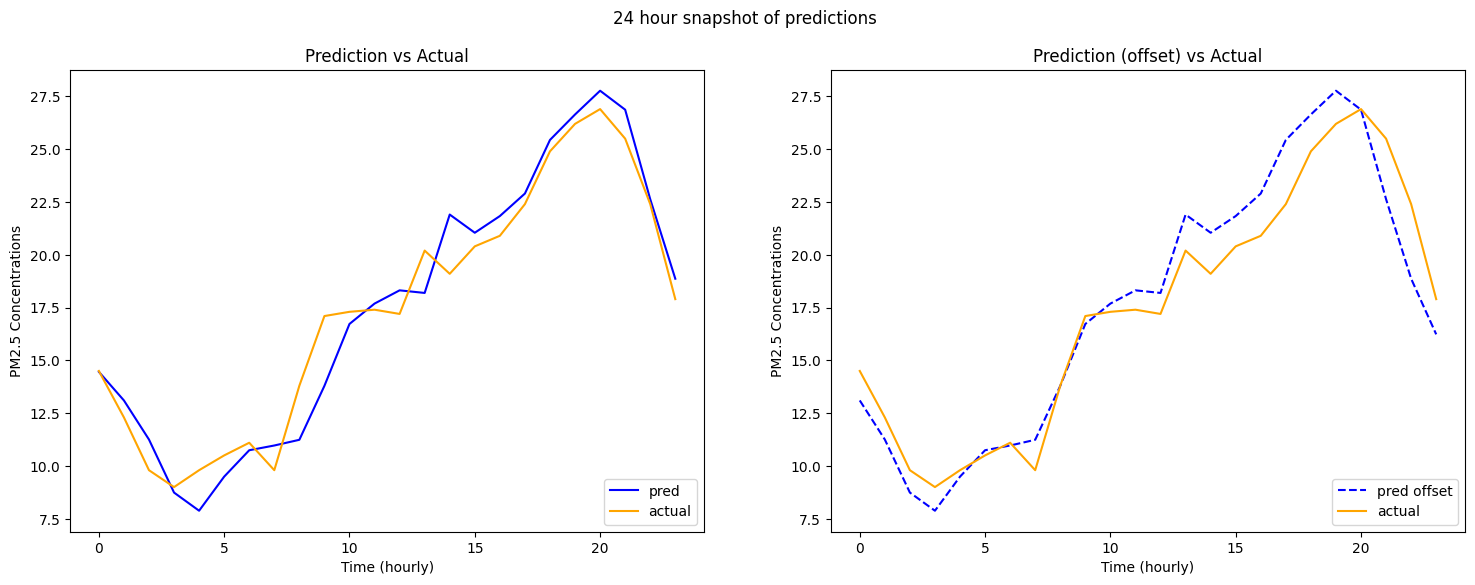

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions")

axes[0].plot(y_pred[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

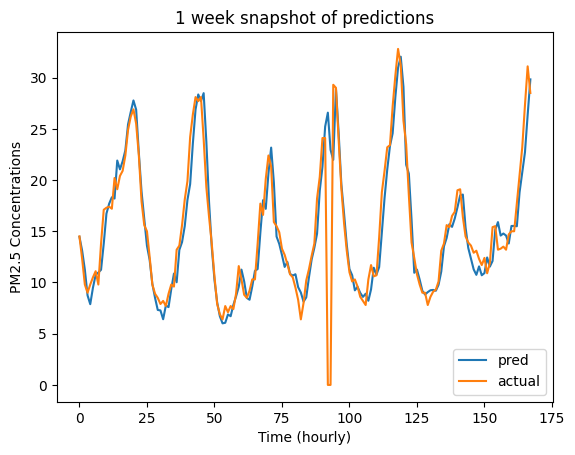

In [23]:
plt.plot(y_pred[1000:1168, 0], label='pred')
plt.plot(Y_test[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")
plt.plot()

In [24]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168, 0], Y_test[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

for i in range(len(cleaned_pred) - 168):
    cleaned_err = nrmse(cleaned_pred[i:i+168], cleaned_test[i:i+168])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(len(y_pred), len(cleaned_pred))

2631 2615


In [25]:
# train-valid-test
dates = pd.date_range(START_DATE, END_DATE, freq='h')[:len(Y_train) + len(Y_valid) + len(Y_test)]
print(dates.shape)
y_test_start_idx = len(Y_train) + len(Y_valid)
print(dates[y_test_start_idx:].shape) # 2631

cleaned_test_dates = np.delete(dates[y_test_start_idx:], dead_sens, 0)
cleaned_test_dates.shape

(17535,)
(2631,)


(2615,)

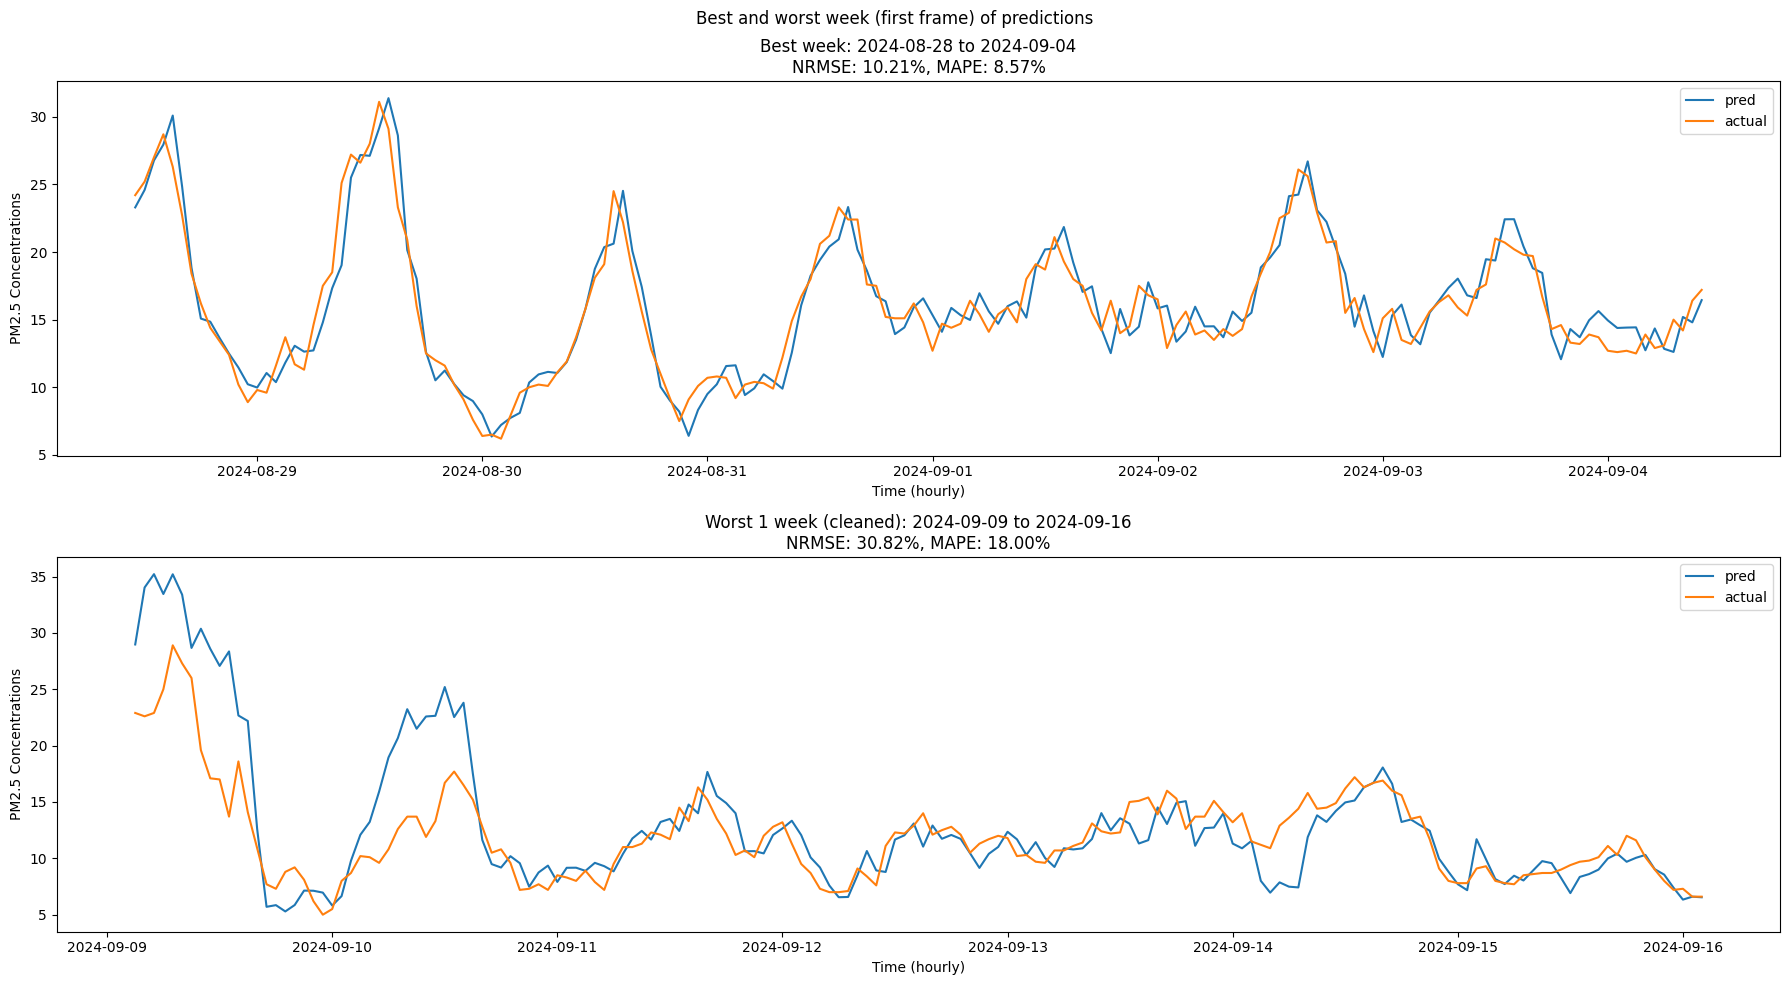

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx : best_idx + 168]), 
        np.squeeze(y_pred[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week (cleaned)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168, 0], 
    label='pred'
)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week (cleaned): {cleaned_test_dates[worst_idx_cleaned].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_cleaned + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week_cleaned:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_cleaned : worst_idx_cleaned + 168]), 
        np.squeeze(y_pred[worst_idx_cleaned : worst_idx_cleaned + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

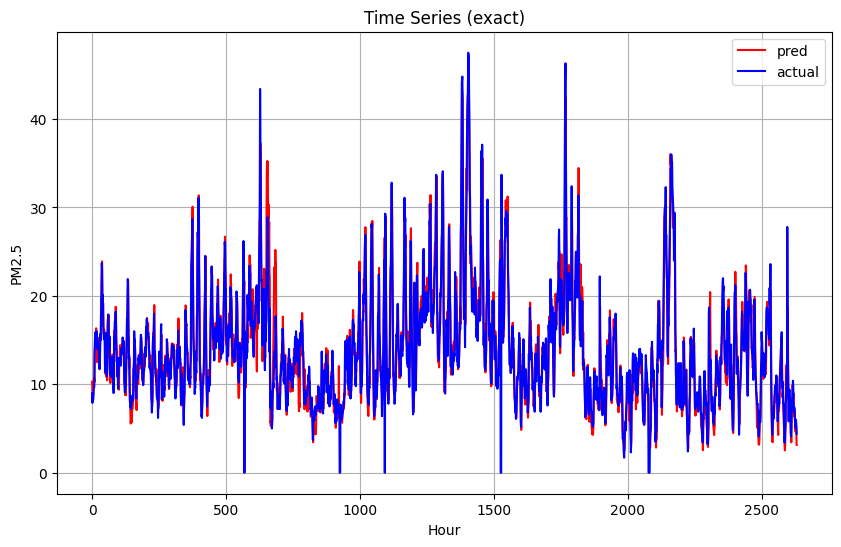

In [27]:
series_pred = pd.Series(np.squeeze(y_pred[:, 0]))
series_test = pd.Series(np.squeeze(Y_test[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(series_pred, label=f'pred', color='red')
plt.plot(series_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

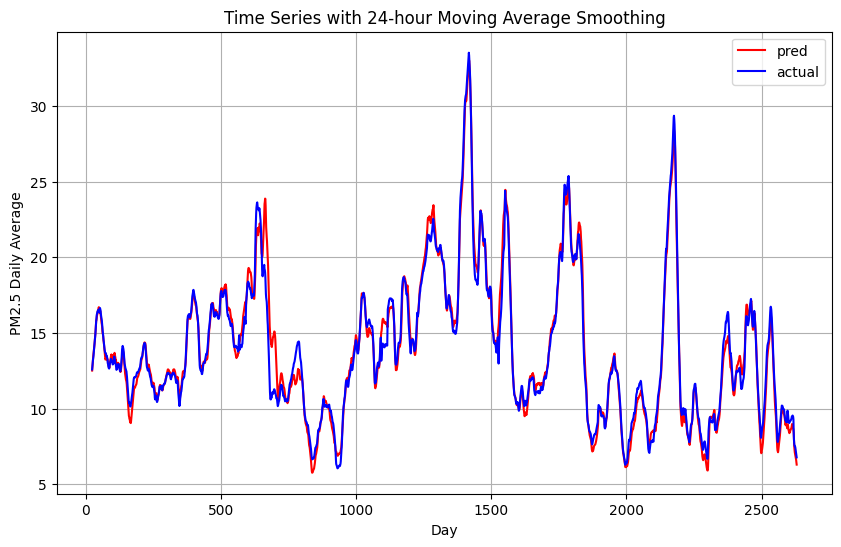

In [28]:
import pandas as pd

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

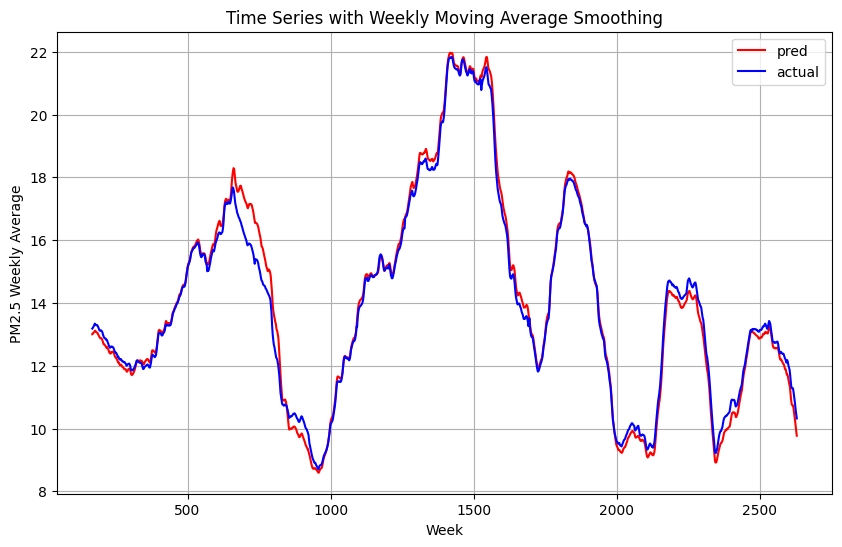

In [29]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

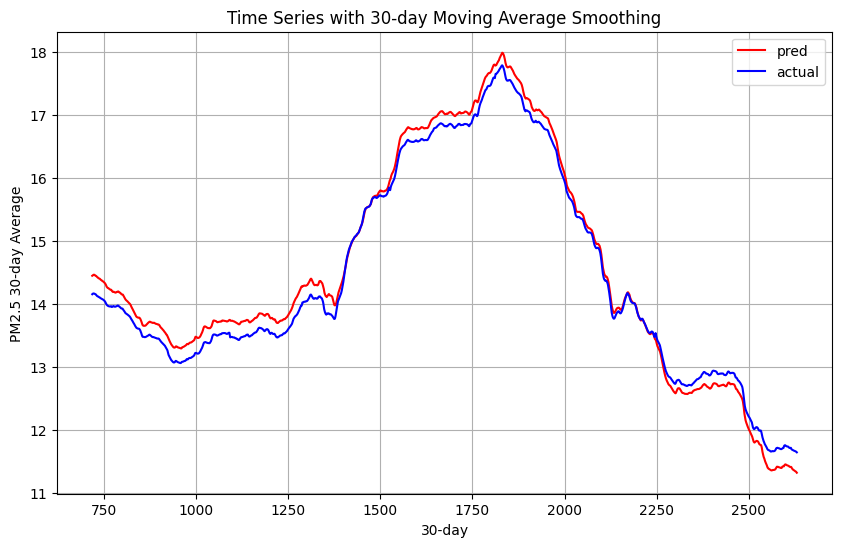

In [30]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

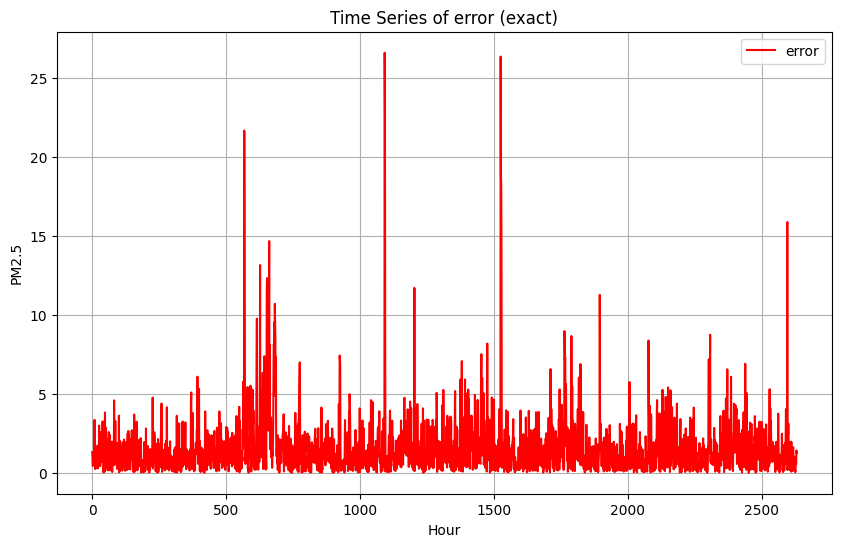

In [31]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0] - Y_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

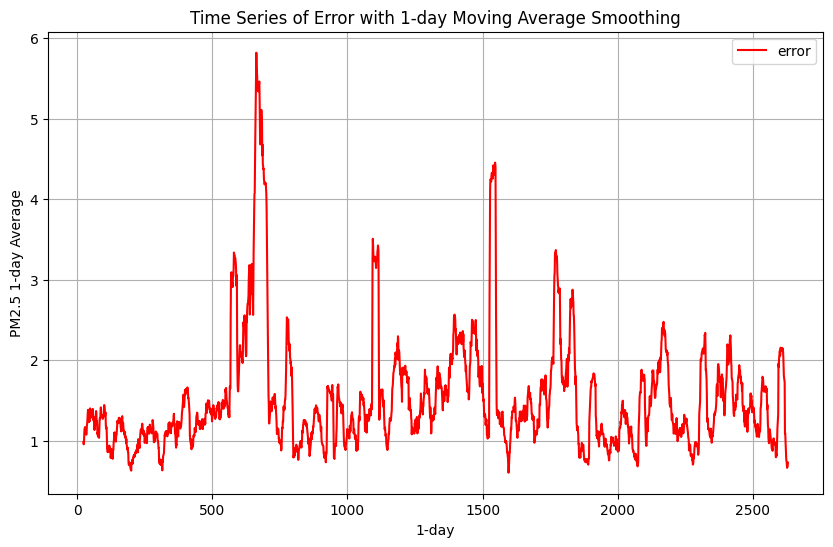

In [32]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

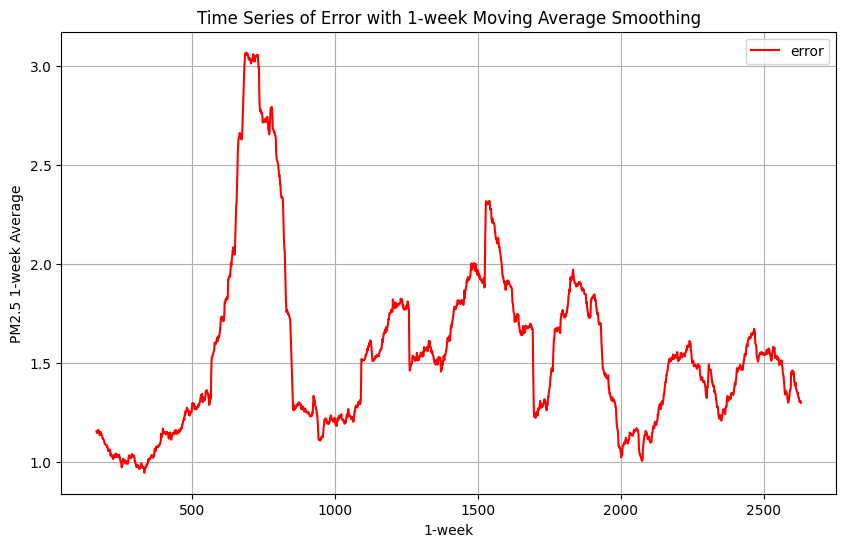

In [33]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

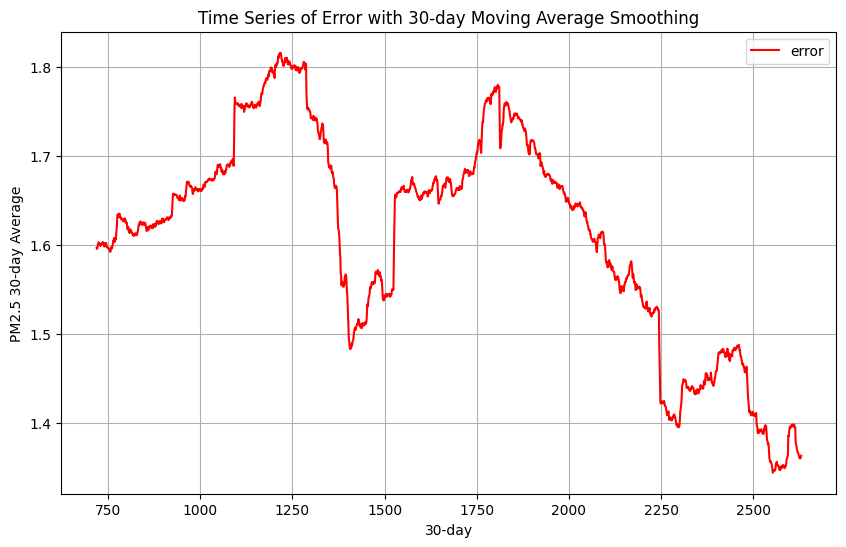

In [34]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

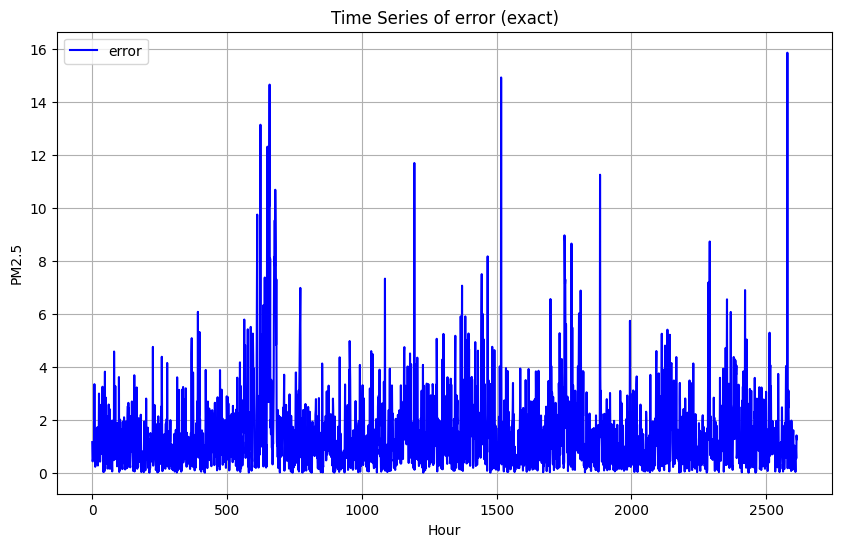

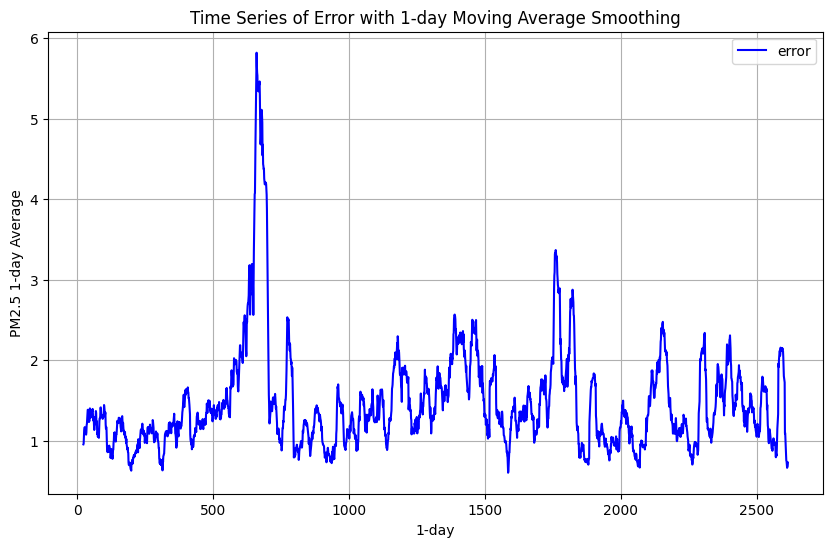

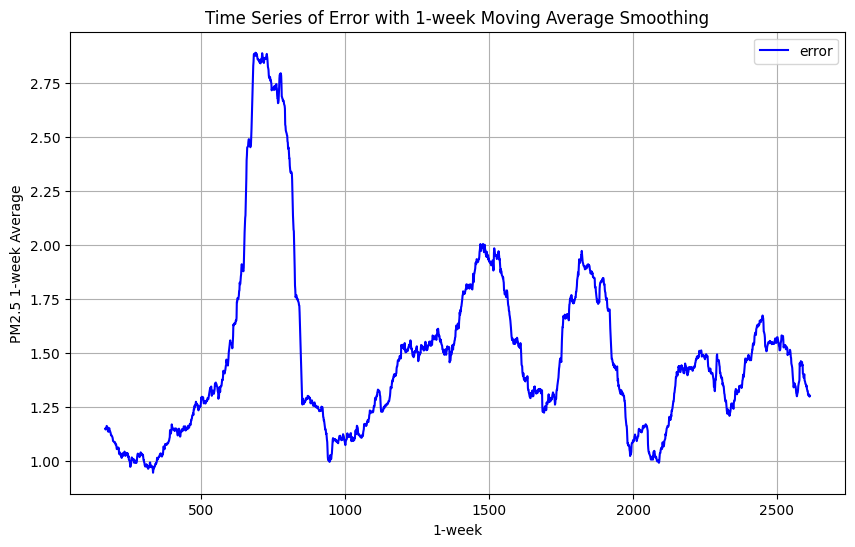

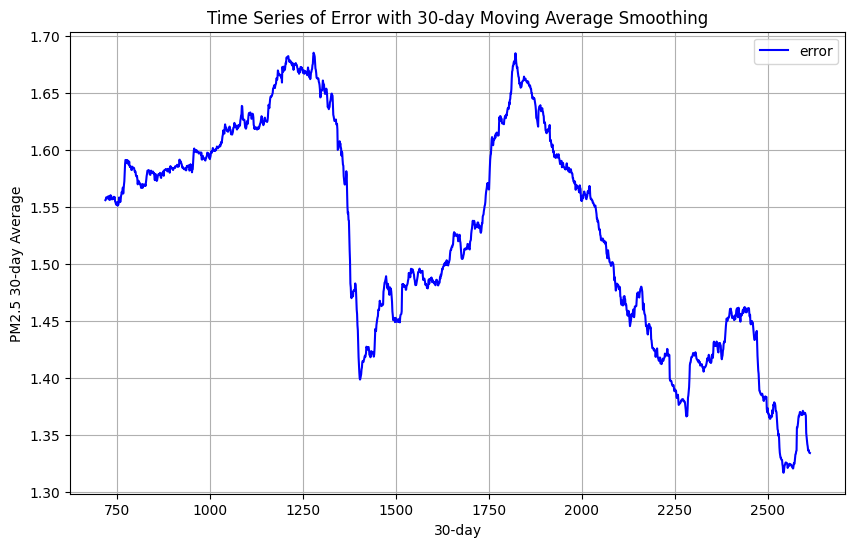

In [35]:
# cleaned plots
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred[:, 0] - cleaned_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

window_size = 24 # daily average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 720 # 30-day average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()